In [1]:
#Import libraries:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split


import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4
import matplotlib
import matplotlib.pyplot as pyplot # for plotting


import gc
import os
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
train = pd.read_csv('train_modified.csv')
test = pd.read_csv('test_modified.csv')
train['target']=train['Disbursed']
train=train.drop('Disbursed',axis=1)
target = 'Disbursed'
IDcol = 'ID'

In [3]:
data=train.append(test)
data.head(2)

,Age,Device_Type_0,Device_Type_1,EMI_Loan_Submitted_Missing,Existing_EMI,Filled_Form_0,Filled_Form_1,Gender_0,Gender_1,ID,...,Var2_0,Var2_1,Var2_2,Var2_3,Var2_4,Var2_5,Var2_6,Var4,Var5,target
0,37,0,1,1,0.0,1,0,1,0,ID000002C20,...,0,0,0,0,0,0,1,1,0,0.0
1,30,0,1,0,0.0,1,0,0,1,ID000004E40,...,0,0,0,0,0,0,1,3,13,0.0


In [6]:
def initModelPara(data,target,IDcol):
    target = target
    IDcol = IDcol
    predictors = [x for x in data.columns if x not in [IDcol]]
    features = [x for x in data.columns if x not in [IDcol,target]]

    alg = lgb.LGBMClassifier(
     learning_rate =0.1,
     n_estimators=1000,
     max_depth=5,
     min_child_weight=1,
     subsample=0.8,
     colsample_bytree=0.8,
     objective= 'binary',
     nthread=4,
     metric='auc',
     seed=27)
    return alg,predictors,features

def splitData(data,features):
    X = data.loc[~data.target.isna(),features]
    Y = data[~data.target.isna()].target
    X_train, X_test, y_train, y_test = train_test_split( X, Y,test_size = 0.3, random_state = 100,stratify=Y)
    return X,Y,X_train,X_test,y_train,y_test

def prediction(alg,data):
    predictions = alg.predict(data)
    predprob = alg.predict_proba(data)[:,1]
    return predictions,predprob

def modelReport(data,predictions,predprob):
     
    print("Accuracy : %.4g" % metrics.accuracy_score(data, predictions))
    print("AUC Score (Test): %f" % metrics.roc_auc_score(data, predprob))
    
def modelFit(alg,X,Y):
    #Fit the algorithm on the data
    alg.fit(X, Y,eval_metric='auc')
    return alg

def modelPlots(cvresult,evals_results,model):
    # plot AUC from cvresult (lgb.cv)
    x_axis = range(0, len(cvresult['auc-mean']))
    fig, ax = pyplot.subplots()
    ax.plot(x_axis, cvresult['auc-mean'], label='Test')
    #ax.plot(x_axis, cvresult['test-auc-mean'], label='Test')
    ax.legend()
    pyplot.show()
    
    # plot AUC from train (lgb.train)
    x_axis = range(0, len(evals_results['train']['auc']))
    fig, ax = pyplot.subplots()
    ax.plot(x_axis, evals_results['train']['auc'], label='Train')
    ax.plot(x_axis, evals_results['valid']['auc'], label='Test')
    ax.legend()
    pyplot.show()    
    
    # Plot importance
    lgb.plot_importance(model,importance_type="split", title="split",max_num_features=10,height=0.5)
    plt.show()
    lgb.plot_importance(model, importance_type="gain", title='gain',max_num_features=10,height=0.5)
    plt.show()

    #ROC c 
    #tn, fp, fn, tp = confusion_matrix([0, 1, 0, 1], [1, 1, 1, 0]).ravel()
    
#Testing using 2 methods namely lgb.cv method and lgb.train method 
def modelTest(alg,X_train,y_train,X_test,y_test,metric,early_stopping_rounds):
    lgb_params = alg.get_params()
    lgb_train = lgb.Dataset(data=X_train, label=y_train)
    lgb_eval = lgb.Dataset(data=X_test, label=y_test)
    cvresult = lgb.cv(lgb_params,lgb_train, nfold = 3, metrics = metric, early_stopping_rounds =early_stopping_rounds,
                      seed = 100,verbose_eval=10)
    alg.set_params(n_estimators=len(cvresult['auc-mean']))
    
    lgb_params=alg.get_params()
    evals_results = {}
    model = lgb.train(lgb_params,lgb_train,valid_sets=[lgb_train,lgb_eval],verbose_eval=10,valid_names=['train','valid']
                      ,evals_result=evals_results)
    algo=modelFit(alg,X_train,y_train)
    
    print("\nModel Report-Train")
    predictionTr,predprobTr=prediction(algo,X_train)
    modelReport(y_train,predictionTr,predprobTr)
    
    print("\nModel Report-Test")
    predictionTe,predprobTe=prediction(algo,X_test)
    modelReport(y_test,predictionTe,predprobTe)
    
    modelPlots(cvresult,evals_results,model)
    return alg
     
def modelPredict(data,alg,X,Y,features):
    alg=modelFit(alg,X,Y)
    #Predicting for the test set 
    testD=data.loc[data.target.isna(),features]
    testD['predprob'] = alg.predict_proba(testD)[:,1]
    testD.to_csv("Prediction.csv",index=False)       

[10]	cv_agg's auc: 0.829396 + 0.00378279
[20]	cv_agg's auc: 0.830851 + 0.00347481
[30]	cv_agg's auc: 0.831793 + 0.0029203
[40]	cv_agg's auc: 0.833629 + 0.00273869
[50]	cv_agg's auc: 0.833759 + 0.00358252
[60]	cv_agg's auc: 0.83491 + 0.00377431
[70]	cv_agg's auc: 0.836707 + 0.00427216
[80]	cv_agg's auc: 0.837876 + 0.00362007
[90]	cv_agg's auc: 0.837276 + 0.00364127
[100]	cv_agg's auc: 0.838218 + 0.00297103
[110]	cv_agg's auc: 0.838437 + 0.00269462
[120]	cv_agg's auc: 0.838579 + 0.00305729
[130]	cv_agg's auc: 0.837828 + 0.00240512
[140]	cv_agg's auc: 0.837164 + 0.00312471
[150]	cv_agg's auc: 0.836581 + 0.00198684
[160]	cv_agg's auc: 0.83549 + 0.00197278
[10]	train's auc: 0.859776	valid's auc: 0.814205
[20]	train's auc: 0.865156	valid's auc: 0.817586
[30]	train's auc: 0.868839	valid's auc: 0.820126
[40]	train's auc: 0.877189	valid's auc: 0.821111
[50]	train's auc: 0.882034	valid's auc: 0.823444
[60]	train's auc: 0.885622	valid's auc: 0.825608
[70]	train's auc: 0.888865	valid's auc: 0.8279

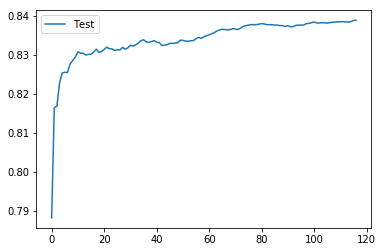

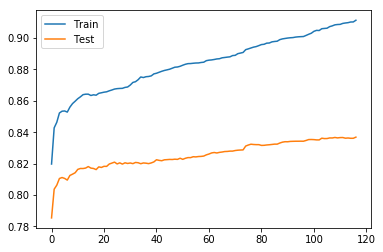

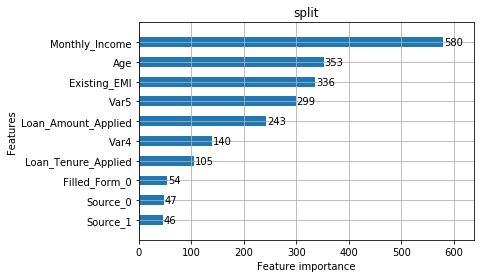

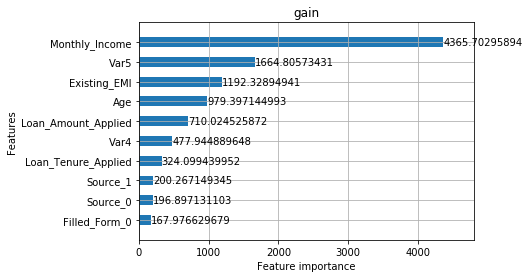

In [7]:
#Choose all predictors except target & IDcols
alg,predictors,features=initModelPara(data,'target','ID')
X,Y,X_train,X_test,y_train,y_test=splitData(data,features)
alg =modelTest(alg,X_train,y_train,X_test,y_test,'auc',50)
modelPredict(data,alg,X,Y,features)